## Number of Transactions Modelling

### 0 - Begin Spark and read in data

In [1]:
from pyspark.sql import SparkSession, functions as F

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "3g")
    .config("spark.driver.memory", "3g")
    .getOrCreate()
)

24/10/02 01:51:19 WARN Utils: Your hostname, MacBook.local resolves to a loopback address: 127.0.0.1; using 192.168.0.6 instead (on interface en0)
24/10/02 01:51:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/02 01:51:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/02 01:51:24 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/10/02 01:51:24 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
revenue_df = spark.read.parquet('../data/curated/revenue.parquet')
revenue_df.show(20, truncate = False)

24/10/02 01:51:36 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+------------+--------------+-------------------------+--------------------------------------------------+------------+---------+----------------+------------------+----------+------------+-----------------+---------+-------------+--------------------+------------------------+----------------------------------+----------------------------------+-----------+------------------+-----------------------------+--------------------+-----------------------+-------------------------+------------------+
|merchant_abn|order_datetime|merchant_name            |description                                       |revenue_band|take_rate|industry_segment|revenue           |male_count|female_count|undisclosed_count|num_trans|num_postcodes|num_unique_customers|sum_customer_mean_income|average_consumer_fraud_probability|average_merchant_fraud_probability|fraud_count|mean_trans_val    |expected_customer_mean_income|first_order_datetime|days_since_first_record|days_since_first_record_2|cumulative_revenue|
+-

### 1 - Create model for ABN = 10023283211

In [3]:
# Take single ABN for trial
merchant_abn = 10023283211
merchant_df = revenue_df.filter(revenue_df['merchant_abn'] == merchant_abn)

print("Number of entries =", merchant_df.count())
merchant_df.show(20, truncate = False)

Number of entries = 604
+------------+--------------+-------------+---------------------------------------------------------------------------------+------------+---------+----------------+------------------+----------+------------+-----------------+---------+-------------+--------------------+------------------------+----------------------------------+----------------------------------+-----------+------------------+-----------------------------+--------------------+-----------------------+-------------------------+------------------+
|merchant_abn|order_datetime|merchant_name|description                                                                      |revenue_band|take_rate|industry_segment|revenue           |male_count|female_count|undisclosed_count|num_trans|num_postcodes|num_unique_customers|sum_customer_mean_income|average_consumer_fraud_probability|average_merchant_fraud_probability|fraud_count|mean_trans_val    |expected_customer_mean_income|first_order_datetime|days_since

In [4]:
# Split into training and test df
split_point = int(merchant_df.count() * 0.8)

train_data = merchant_df.limit(split_point)
test_data = merchant_df.subtract(train_data).orderBy('order_datetime')

In [6]:
import pandas as pd
train_pd = train_data.select('order_datetime', 'num_trans').toPandas()
test_pd = test_data.select('order_datetime', 'num_trans').toPandas()

# Convert 'order_datetime' to date time data type
train_pd['order_datetime'] = pd.to_datetime(train_pd['order_datetime'])
train_pd.set_index('order_datetime', inplace = True)
test_pd['order_datetime'] = pd.to_datetime(test_pd['order_datetime'])
test_pd.set_index('order_datetime', inplace = True)

# Missing day -> 0 transactions on date
full_range = pd.date_range(start = train_pd.index.min(), end = train_pd.index.max(), freq = 'D')
train_pd = train_pd.reindex(full_range).fillna(0)
full_range = pd.date_range(start = test_pd.index.min(), end = test_pd.index.max(), freq = 'D')
test_pd = test_pd.reindex(full_range).fillna(0)

24/10/02 01:59:51 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [11]:
test_pd.tail()

,num_trans
2022-10-22,4.0
2022-10-23,7.0
2022-10-24,7.0
2022-10-25,9.0
2022-10-26,11.0


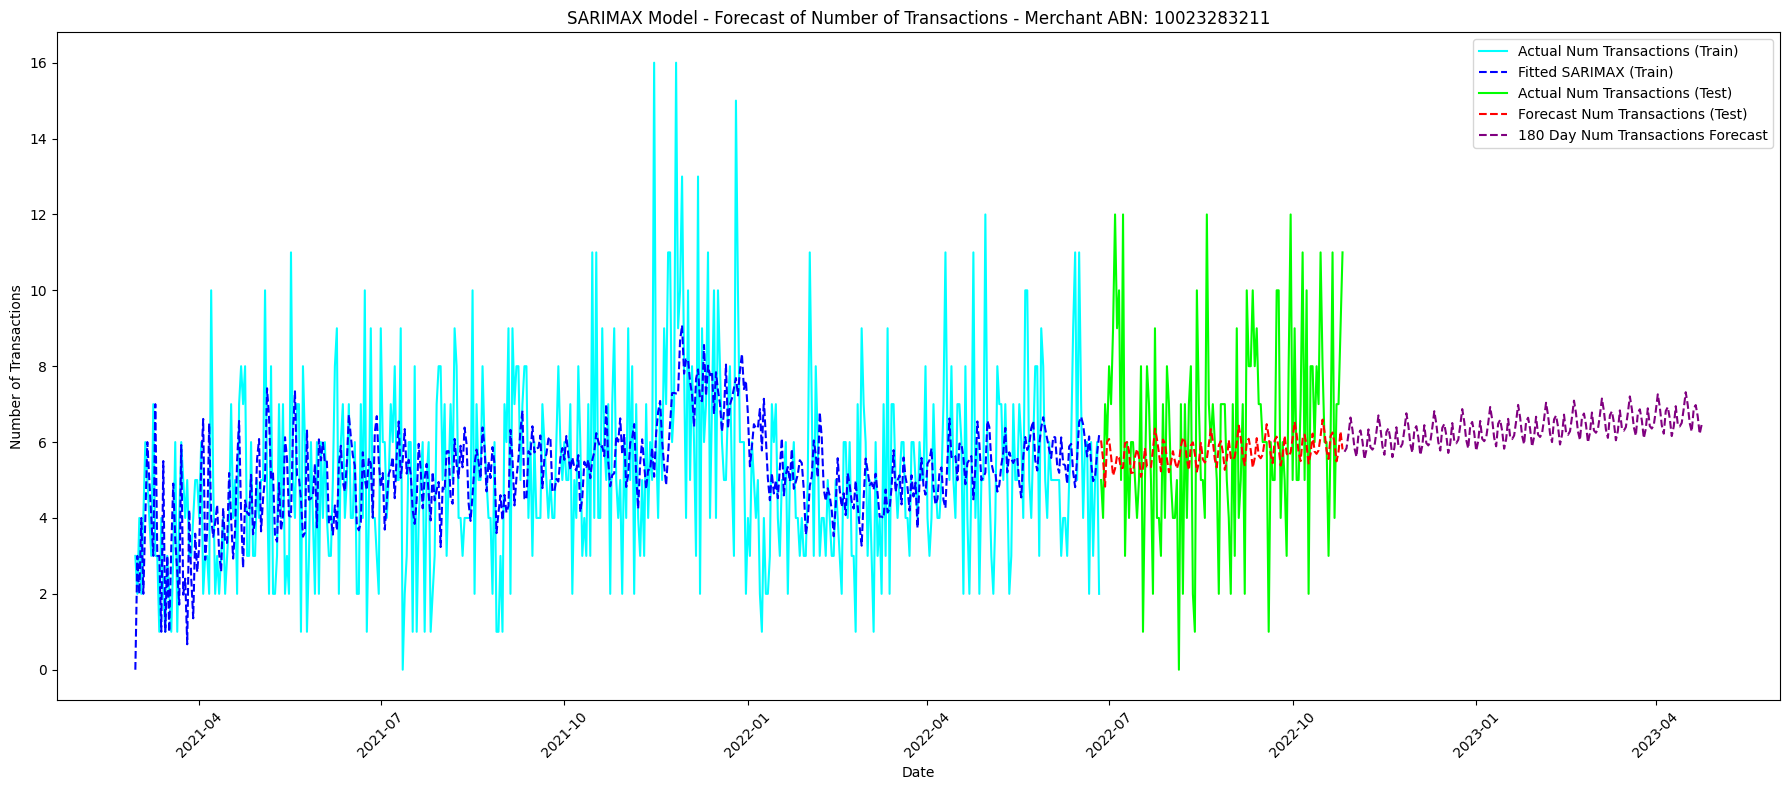

Training RMSE = 2.5377694371621073
Testing RMSE = 2.6578349886222945


In [99]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

time_series_data = train_pd['num_trans']

model = SARIMAX(time_series_data, order = (3, 1, 1), seasonal_order = (3, 1, 1, 14), freq = 'D')
fitted_model = model.fit(maxiter = 500, disp = False)

# Get in-sample predictions for RMSE calculation
in_sample_predictions = fitted_model.fittedvalues

# Forecasting on test data
forecast_steps = len(test_pd)
forecast_test = fitted_model.forecast(steps = forecast_steps)

# Forecasting for the next 180 days after the test set
forecast_180_days = fitted_model.forecast(steps = len(test_pd) + 180)

# Create forecast index for 180 days
last_date = test_pd.index[-1]
forecast_index_180_days = pd.date_range(start = last_date + pd.DateOffset(days = 1), periods = len(test_pd) + 180, freq = 'D')
forecast_series_180_days = pd.Series(forecast_180_days, index = forecast_index_180_days)

# RMSE calculations
rmse_train = np.sqrt(mean_squared_error(time_series_data, in_sample_predictions))
rmse_test = np.sqrt(mean_squared_error(test_pd['num_trans'], forecast_test))

# Plotting
plt.figure(figsize = (18, 8))
plt.plot(time_series_data.index, time_series_data, label = 'Actual Num Transactions (Train)', color = 'cyan')
plt.plot(in_sample_predictions.index, in_sample_predictions, label = 'Fitted SARIMAX (Train)', color = 'blue', linestyle = '--')
plt.plot(test_pd.index, test_pd['num_trans'], label = 'Actual Num Transactions (Test)', color = 'lime')
plt.plot(test_pd.index, forecast_test, label = 'Forecast Num Transactions (Test)', color = 'red', linestyle = '--')
plt.plot(forecast_series_180_days.index, forecast_series_180_days, label = '180 Day Num Transactions Forecast', color = 'purple', linestyle = '--')

# Title and axis labels
plt.title('SARIMAX Model - Forecast of Number of Transactions - Merchant ABN: 10023283211')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.legend()

plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

# Print RMSE values
print("Training RMSE =", rmse_train)
print("Testing RMSE =", rmse_test)

In [98]:
print(forecast_180_days)

2022-06-27    5.063408
2022-06-28    4.692425
2022-06-29    4.604731
2022-06-30    5.400017
2022-07-01    5.676684
                ...   
2023-04-20    6.975924
2023-04-21    6.974957
2023-04-22    6.274582
2023-04-23    6.641696
2023-04-24    6.198078
Freq: D, Name: predicted_mean, Length: 302, dtype: float64
